# Perfume Chatbot Information Retrieval Recommendations Demo

In [1]:
from src.information_retrieval_model import Perfume_Information_Retrieval_Model

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pir = Perfume_Information_Retrieval_Model()

In [5]:
from IPython.display import display
from ipywidgets import widgets
from IPython.display import clear_output


print("Describe the perfume you are looking for. You can be as detailed as you like! ")
text = widgets.Text()
display(text)
button = widgets.Button(description="Restart!")
display(button)

def on_button_clicked(b):
    clear_output()
    print("Describe the perfume you are looking for. You can be as detailed as you like! ")
    display(text)
    display(button)

def handle_submit(sender):
    print("Got it! Hold tight while I find your recommendations!")
    message = text.value
    recs = pir.query_similar_perfumes(message, 5)
    pir.view_recommendations(recs)

text.on_submit(handle_submit)
button.on_click(on_button_clicked)

Describe the perfume you are looking for. You can be as detailed as you like! 


Text(value='')

Button(description='Restart!', style=ButtonStyle())

                                                    semantic_similarity  \
title                                                                     
1270 Eau de Parfum by Frapin                                   0.555807   
Geisha Rouge roll-on perfume oil by Aroma M                    0.582592   
Mure et Musc Extreme Eau de Parfum by L'Artisan...             0.568192   
Tilda Swinton Like This Eau de Parfum by Etat L...             0.528870   
Vraie Blonde Eau de Parfum by Etat Libre d'Orange              0.501202   

                                                    bow_similarity  \
title                                                                
1270 Eau de Parfum by Frapin                              0.891549   
Geisha Rouge roll-on perfume oil by Aroma M               0.859242   
Mure et Musc Extreme Eau de Parfum by L'Artisan...        0.809029   
Tilda Swinton Like This Eau de Parfum by Etat L...        0.846886   
Vraie Blonde Eau de Parfum by Etat Libre d'Orange     

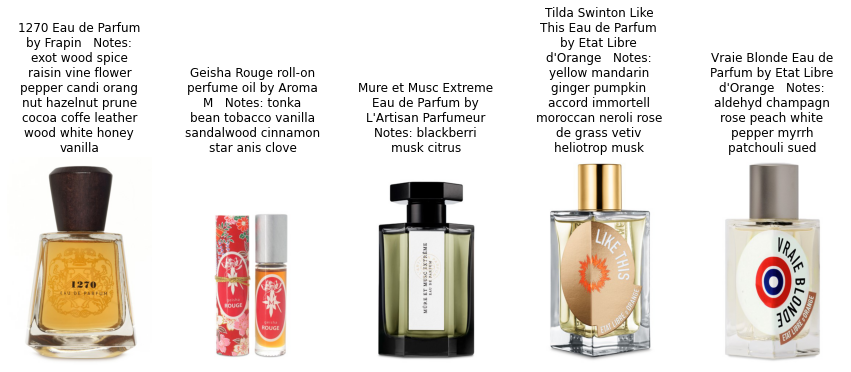

In [17]:
#widget not working in sagemaker. so lame. gettign predictions manually with this
#message = "I love chinese food and sushi. salmon and oysters and sea salty yummy! Hate flowers they smell horrible."
#message = "I am looking for something similar to miu miu, but higher quality. Like lilly and apple."
#message = "hey bitch"
#message = "I am looking for my wedding scent. The wedding will be small and intimate event. Outdoor venue in the forest. Think wood nympth glam forest fairly vibes."
message = "Going on a date. Want to smell sweet and sexy!"
message = "Going on a date. Want to smell sweet and sexy!. I really dislike vanilla though"
recs = pir.query_similar_perfumes(message, 5)
print(recs)
pir.view_recommendations(recs)